dataset link: https://www.kaggle.com/datasets/hadiepratamatulili/anime-vs-cartoon-vs-human

In [ ]:
# To get multi output in jupyternotebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout ,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

#### Bunu birkez resimleri istediğimiz formatta dosyalamak için çalıştırın :
```
processed_data/
├── train/
│   ├── anime/
│   ├── cartoon/
│   └── human/
└── test/
    ├── anime/
    ├── cartoon/
    └── human/
```



In [ ]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

random.seed(42)  # Tekrarlanabilirlik

base_dir = 'data'
output_base = 'processed_data'  # yeni dizin yapısı

categories = ['anime', 'cartoon', 'human']

for category in categories:
    src_folder = os.path.join(base_dir, category)
    images = os.listdir(src_folder)
    train_files, test_files = train_test_split(images, test_size=0.2, random_state=42)

    for split, file_list in [('train', train_files), ('test', test_files)]:
        dest_folder = os.path.join(output_base, split, category)
        os.makedirs(dest_folder, exist_ok=True)
        
        for file_name in file_list:
            src_path = os.path.join(src_folder, file_name)
            dest_path = os.path.join(dest_folder, file_name)
            shutil.copy2(src_path, dest_path)


### Resimleri Yükleme

In [2]:
# Veri artırma ve normalizasyon
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'processed_data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True  # VERİYİ KARIŞTIRIYOR
)

test_generator = test_datagen.flow_from_directory(
    'processed_data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True  # TESTTE DE İSTİYORSAN KARIŞTIRABİLİRSİN
)


Found 7133 images belonging to 3 classes.
Found 1784 images belonging to 3 classes.


In [28]:
train_generator.classes   # her bir categoriden kaç adet var görmek için ?
np.bincount(train_generator.classes)  # dengeli bir dağılım var

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

array([2403, 2330, 2400])

### görselleştirme

<Figure size 1200x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'cartoon')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'human')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'anime')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

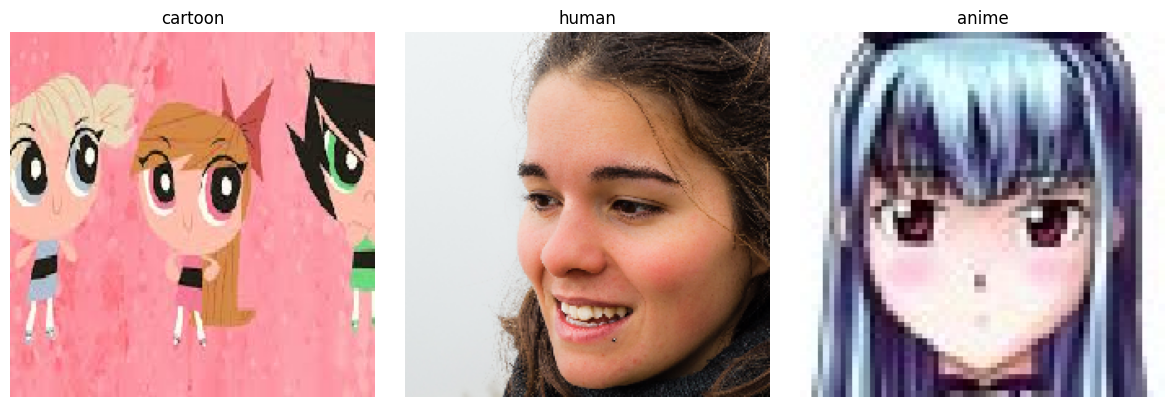

In [ ]:
labels = list(train_generator.class_indices.keys())  # ['anime', 'cartoon', 'human']

x_batch, y_batch = train_generator[0]  # İlk batch

# y_batch one-hot olduğu için argmax ile sınıf index'ini alıyoruz
y_labels = np.argmax(y_batch, axis=1)

# Her sınıftan bir tane örnek çizelim
plotted_classes = set()

plt.figure(figsize=(12, 4))

i = 0
while len(plotted_classes) < len(labels) and i < len(x_batch):
    label_index = y_labels[i]
    if label_index not in plotted_classes:
        plt.subplot(1, len(labels), len(plotted_classes) + 1)
        plt.imshow(x_batch[i])
        plt.title(f"{labels[label_index]}")
        plt.axis("off")
        plotted_classes.add(label_index)
    i += 1

plt.tight_layout()
plt.show()

## CNN Model kurulumu ve Eğitimi

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 sınıf olduğu için
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\Harun\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    epochs=3,
    validation_data=test_generator
)

c:\Users\Harun\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
223/223 ━━━━━━━━━━━━━━━━━━━━ 196s 872ms/step - accuracy: 0.7785 - loss: 0.7918 - val_accuracy: 0.9860 - val_loss: 0.0436
Epoch 2/3
223/223 ━━━━━━━━━━━━━━━━━━━━ 204s 916ms/step - accuracy: 0.9848 - loss: 0.0523 - val_accuracy: 0.9854 - val_loss: 0.0509
Epoch 3/3
223/223 ━━━━━━━━━━━━━━━━━━━━ 200s 896ms/step - accuracy: 0.9917 - loss: 0.0285 - val_accuracy: 0.9961 - val_loss: 0.0159


## CNN Model Değerlendirme Görselleştirme

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Doğruluk')

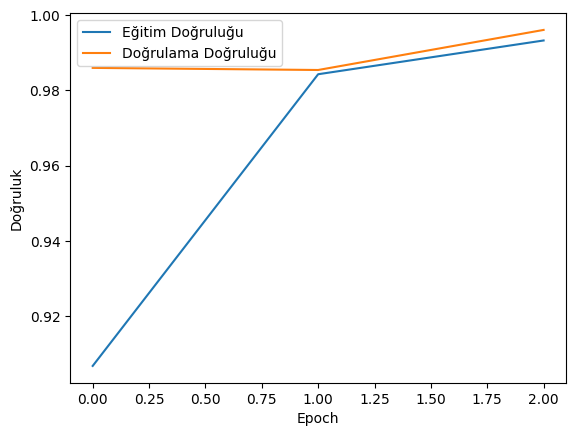

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()


## CNN Model Tahmin Görselleştirme

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


<Figure size 1200x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Gerçek: cartoon\nTahmin: cartoon')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: human\nTahmin: human')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: anime\nTahmin: anime')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: anime\nTahmin: anime')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: human\nTahmin: human')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: cartoon\nTahmin: cartoon')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

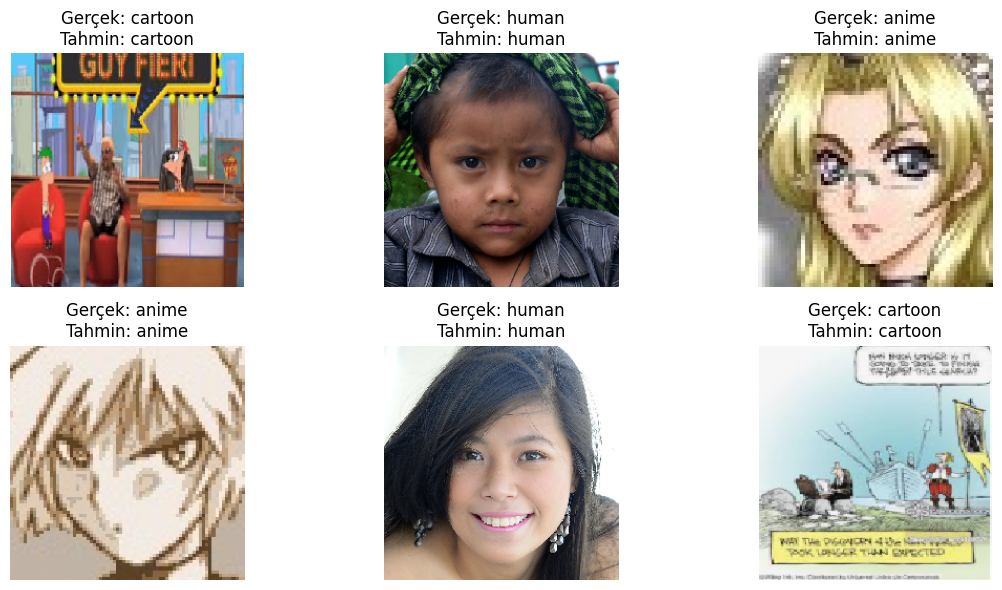

In [ ]:
x_test, y_test = test_generator[0]

# Gerçek etiketler
true_labels = np.argmax(y_test, axis=1)

# Tahminler
pred_probs = model.predict(x_test)
pred_labels = np.argmax(pred_probs, axis=1)

plt.figure(figsize=(12, 6))

for i in range(6):  # İlk 6 görseli çizelim
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_test[i])
    plt.title(f"Gerçek: {labels[true_labels[i]]}\nTahmin: {labels[pred_labels[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## MobileNetV2 Model Kurulumu ve Eğitimi

In [ ]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # İlk eğitimde sadece son katmanlar eğitilsin gövde eğitilmiek sadece baş eğitiliecek

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

model_mobilenet = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model_mobilenet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_mobilenet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history_mobilenet = model_mobilenet.fit(
    train_generator,
    validation_data=test_generator,
    epochs=3
)

Epoch 1/3
223/223 ━━━━━━━━━━━━━━━━━━━━ 209s 939ms/step - accuracy: 0.9919 - loss: 0.0567 - val_accuracy: 1.0000 - val_loss: 0.0061
Epoch 2/3
223/223 ━━━━━━━━━━━━━━━━━━━━ 210s 941ms/step - accuracy: 0.9988 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 3/3
223/223 ━━━━━━━━━━━━━━━━━━━━ 202s 905ms/step - accuracy: 0.9978 - loss: 0.0072 - val_accuracy: 1.0000 - val_loss: 0.0014


## MobileNet Model Değerlendirme ve CNN ile Karşılaştırma Görselleştirilmesi

Text(0.5, 1.0, 'CNN Model')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Doğruluk')

Text(0.5, 1.0, 'MobileNetV2 Model')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Doğruluk')

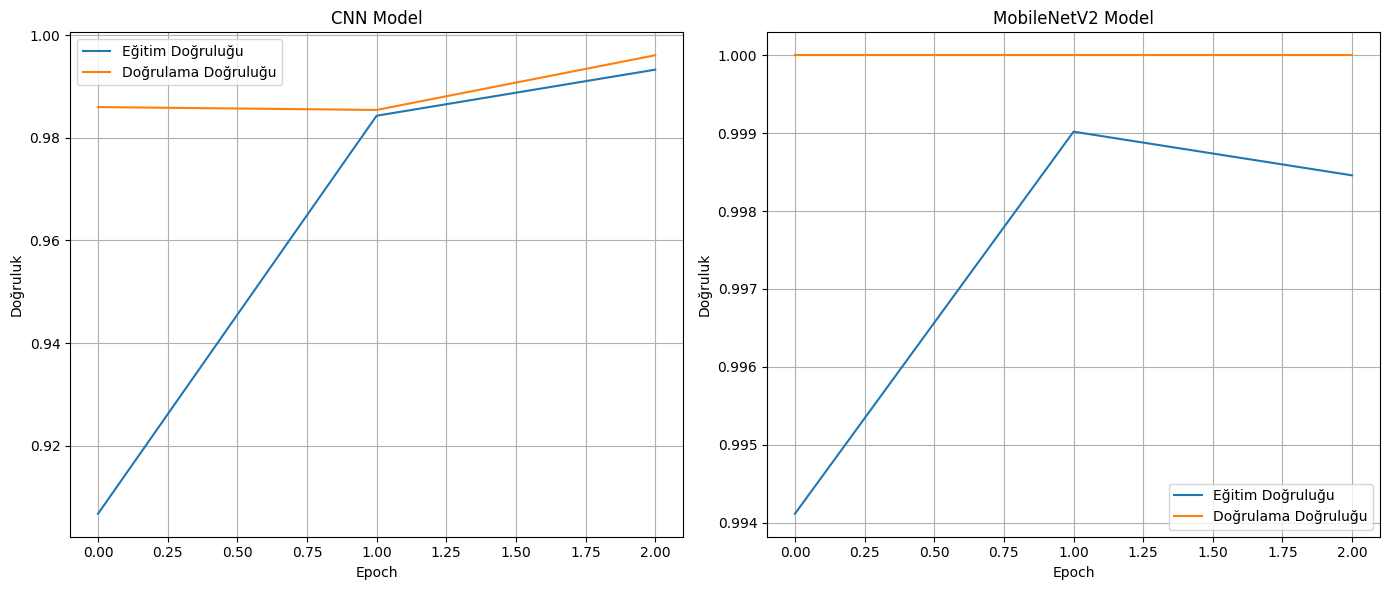

In [ ]:
import matplotlib.pyplot as plt

# Şekil ve eksenleri tanımla
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 satır, 2 sütunluk grafik

axes[0].plot(history.history['accuracy'], label='Eğitim Doğruluğu')
axes[0].plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
axes[0].set_title("CNN Model")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Doğruluk")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_mobilenet.history['accuracy'], label='Eğitim Doğruluğu')
axes[1].plot(history_mobilenet.history['val_accuracy'], label='Doğrulama Doğruluğu')
axes[1].set_title("MobileNetV2 Model")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Doğruluk")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## MobileNet Model Tahmin Görselleştirme

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


<Figure size 1200x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Gerçek: human\nTahmin: human')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: human\nTahmin: human')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: human\nTahmin: human')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: human\nTahmin: human')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: anime\nTahmin: anime')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: human\nTahmin: human')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: human\nTahmin: human')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: cartoon\nTahmin: cartoon')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Gerçek: human\nTahmin: human')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

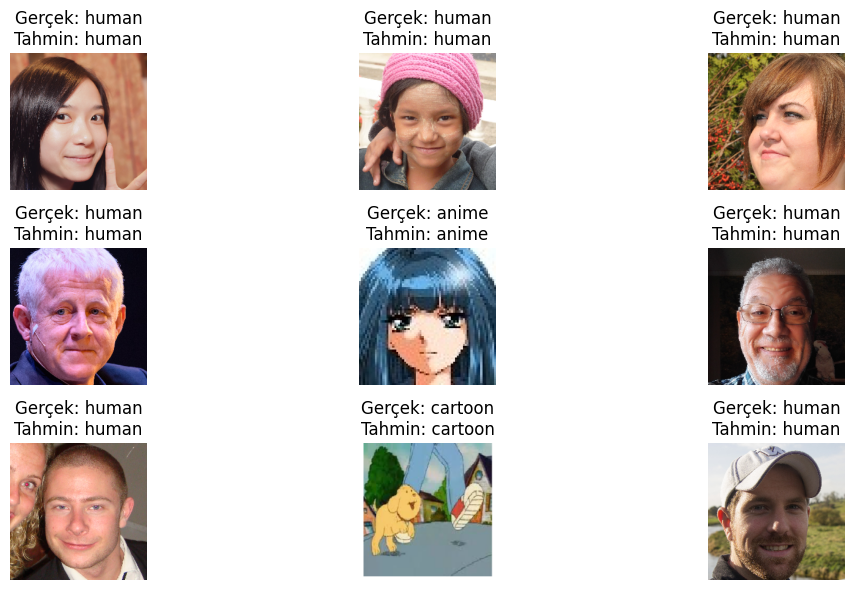

In [ ]:
x_test, y_test = test_generator[0]

true_labels = np.argmax(y_test, axis=1)

pred_probs = model_mobilenet.predict(x_test)
pred_labels = np.argmax(pred_probs, axis=1)

labels = list(train_generator.class_indices.keys())

plt.figure(figsize=(12, 6))

for i in range(9):  
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[i])
    plt.title(f"Gerçek: {labels[true_labels[i]]}\nTahmin: {labels[pred_labels[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()